# Model Selection
--- 
This notebook explores different classification algorithms and evaluates them. We choose the most appropriate result to go forward with from these results.

In [1]:
import os, pickle, itertools, glob, re, datetime

from joblib import dump, load

import cv2 as cv
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as colors_mat

from tqdm.notebook import tqdm

from params import *

## Data Acquistion

In [2]:
def paths_to_datetimeindex(list):
    pattern = PATTERN_REGEX
    new_list = []
    for item in list:
        time = re.search(pattern, item).group(1)
        time = datetime.strptime(time, '%m-%d-%Y').date()
        new_list.append(time)
    return new_list

In [3]:
band_names = {'band':{1: 'Blue',
                        2: 'Green',
                        3: 'Red',
                        4: 'NIR'
                }}

data_dir = '../' + DOWNLOAD_DIR_TT + '*.tif'
times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(data_dir))]
time_var = xr.Variable('Observation Date', times)
geotiffs_da = xr.concat([rxr.open_rasterio(entry).squeeze() for entry in glob.glob(data_dir)],
                    dim=time_var) 
planet_ds = geotiffs_da.to_dataset(dim='Observation Date')
planet_ds

<xarray.Dataset>
Dimensions:      (band: 6, y: 5850, x: 3536)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6
  * x            (x) float64 6.628e+05 6.628e+05 ... 6.734e+05 6.734e+05
  * y            (y) float64 1.16e+06 1.16e+06 1.16e+06 ... 1.177e+06 1.177e+06
    spatial_ref  int32 0
Data variables:
    01-23-2020   (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    01-28-2023   (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    02-08-2020   (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    02-12-2022   (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    02-14-2022   (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    02-18-2023   (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    03-20-2021   (band, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

Adding NDWI and NDVI layers to help model

In [4]:
"""ndvi_times = []
ndwi_times = []
for time in times:
    ndwi = (planet_ds[time][1] - planet_ds[time][3])/(planet_ds[time][1] + planet_ds[time][3])
    ndvi = (planet_ds[time][3] - planet_ds[time][2])/(planet_ds[time][3] + planet_ds[time][2])
    ndwi_data = xr.DataArray(ndwi, coords={'band' : 'NDWI'})
    ndvi_data = xr.DataArray(ndvi, coords={'band' : 'NDVI'})
    ndvi_times.append(ndvi_data)
    ndwi_times.append(ndwi_data)"""

"ndvi_times = []\nndwi_times = []\nfor time in times:\n    ndwi = (planet_ds[time][1] - planet_ds[time][3])/(planet_ds[time][1] + planet_ds[time][3])\n    ndvi = (planet_ds[time][3] - planet_ds[time][2])/(planet_ds[time][3] + planet_ds[time][2])\n    ndwi_data = xr.DataArray(ndwi, coords={'band' : 'NDWI'})\n    ndvi_data = xr.DataArray(ndvi, coords={'band' : 'NDVI'})\n    ndvi_times.append(ndvi_data)\n    ndwi_times.append(ndwi_data)"

In [5]:
"""ndvi_arr = xr.concat(ndvi_times, dim=time_var).to_dataset(dim='Observation Date')
ndwi_arr = xr.concat(ndwi_times, dim=time_var).to_dataset(dim='Observation Date')
planet_ds = xr.concat([planet_ds, ndvi_arr, ndwi_arr], dim='band')"""

"ndvi_arr = xr.concat(ndvi_times, dim=time_var).to_dataset(dim='Observation Date')\nndwi_arr = xr.concat(ndwi_times, dim=time_var).to_dataset(dim='Observation Date')\nplanet_ds = xr.concat([planet_ds, ndvi_arr, ndwi_arr], dim='band')"

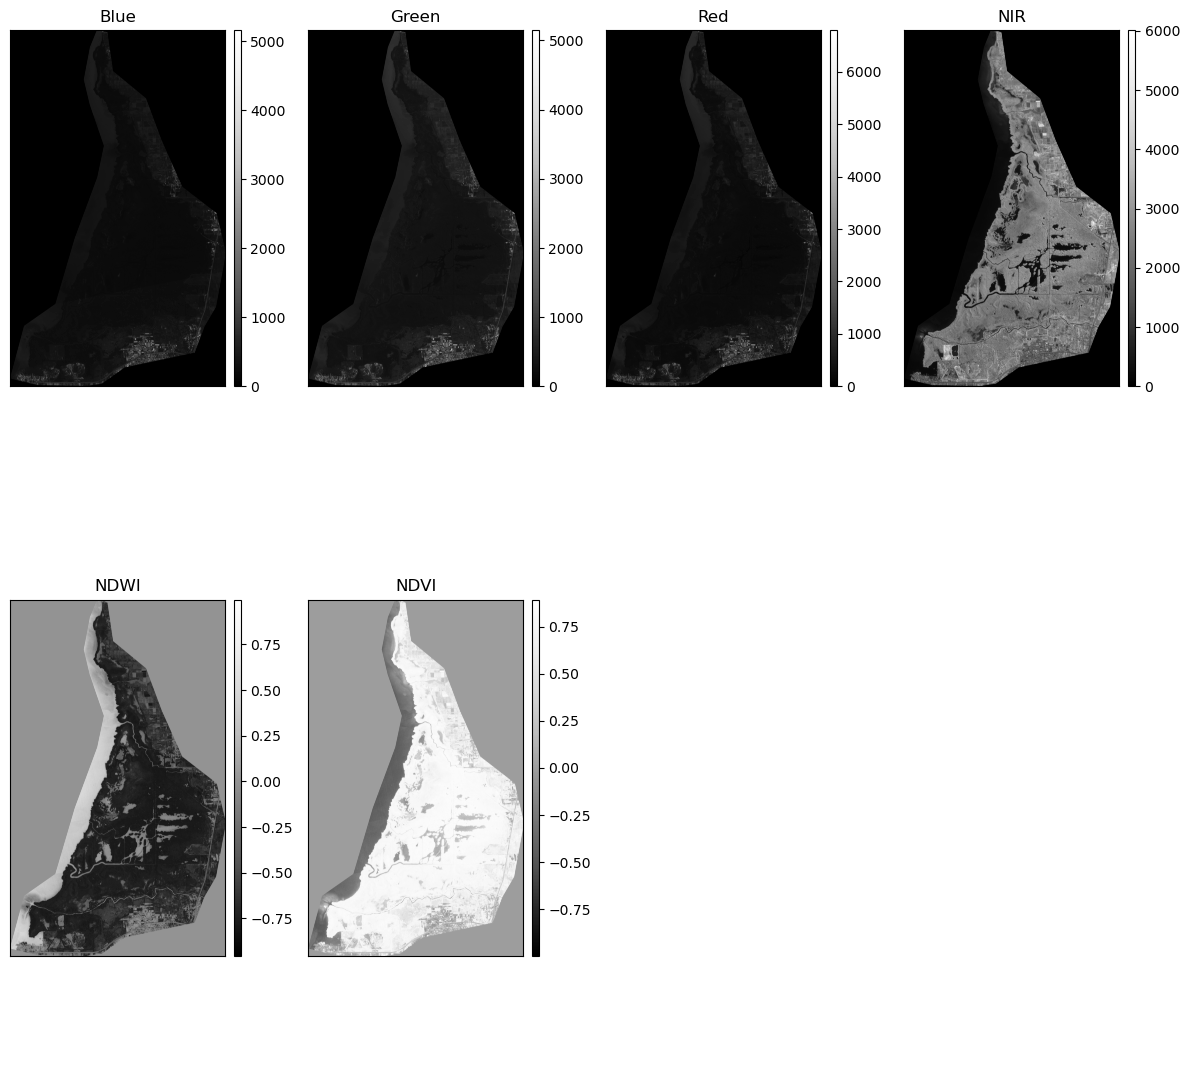

In [6]:
band_titles = ['Blue', 'Green', 'Red', 'NIR', 'NDWI', 'NDVI']
ep.plot_bands(planet_ds[times[0]], cols=4, title=band_titles);

## Classification Model Training

### Preprocessing and Imports

In [7]:
from sklearn.ensemble import  HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Colormap for figure

In [8]:
custom_cmap = colors_mat.ListedColormap(colors=['forestgreen', 'blue', 'tan', 'mediumseagreen', 'gray', 'lightsteelblue'])
boundaries = [0, 1, 2, 3, 4, 5]
custom_norm = colors_mat.BoundaryNorm(boundaries, custom_cmap.N, clip=True)

patches = [mpatches.Patch(color='forestgreen', label='Mangrove'),
            mpatches.Patch(color='blue', label='Water'),
            mpatches.Patch(color='tan', label='Mud Flat'),
            mpatches.Patch(color='mediumseagreen', label='Crops'),
            mpatches.Patch(color='gray', label='Urban'),
            mpatches.Patch(color='lightsteelblue', label='Intertidal Zone'),]

Importing and Formating Training Labels

In [9]:
initial_train = planet_ds['01-23-2020']
# Importing label points
training_labels = gpd.read_file('../' + TRAINING_LABELS_SHP)
# Dropping any possible NaNs from labels
training_labels = training_labels.dropna(axis=0, how='any')

In [10]:
training_labels

,label,id,geometry
0,mangrove,0,POINT (667502.791 1172833.117)
1,mangrove,0,POINT (667502.083 1172835.594)
2,mangrove,0,POINT (665823.407 1172855.764)
3,mangrove,0,POINT (669422.440 1172811.532)
4,mangrove,0,POINT (669852.548 1172738.639)
...,...,...,...
63,water,1,POINT (668908.982 1174471.761)
64,cropland,3,POINT (671889.697 1172103.337)
65,water,1,POINT (664345.889 1174194.706)
66,water,1,POINT (663837.691 1174712.402)


In [11]:
def get_train_test_points(dataset, times):
    X_data = []
    labels = np.array([])
    for time in times:
        print(f"Grabbing pixel values for labels at {time} observation.")
        training_obs = dataset[time]
        # Matching Label Points with Raster Pixels
        # Samples for pixels changes every loop between observations while labelled point positions stay the same
        training_labels['samples'] = training_labels.apply(lambda x: training_obs.rio.clip([x['geometry']], from_disk=True).squeeze().values, axis=1)
        training_labels['samples'] = (training_labels['samples']).apply(lambda x: x.reshape((1, -1)))
        # Train-Test Split
        train_set, test_set = train_test_split(training_labels, test_size=0.3, stratify=training_labels['id'])
        # Reshape data 
        new = []
        temp_data = (training_labels['samples']).apply(lambda x: x.reshape((1, -1)))
        for arr in temp_data.values:
            new.append(arr[0].tolist())
        X_data = X_data + new

        # getting labels repeated for every observation as they are unchanging with position
        labels = np.append(labels, training_labels['id'].values)

    # Split data in train and test
    X_data = np.array(X_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, labels, test_size=0.3, stratify=labels)
    print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape} \ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = get_train_test_points(planet_ds, times)

Grabbing pixel values for labels at 01-23-2020 observation.
Grabbing pixel values for labels at 01-28-2023 observation.
Grabbing pixel values for labels at 02-08-2020 observation.
Grabbing pixel values for labels at 02-12-2022 observation.
Grabbing pixel values for labels at 02-14-2022 observation.
Grabbing pixel values for labels at 02-18-2023 observation.
Grabbing pixel values for labels at 03-20-2021 observation.
X_train Shape: (333, 6)
X_test Shape: (143, 6) 
y_train Shape: (333,)
y_test Shape:(143,)


Pulling Images to be trained on

In [13]:
shapes = initial_train.shape
acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in initial_train]
resh = np.array(acq).reshape(shapes[0], shapes[1]*shapes[2]).transpose()

### Model Initilization and Training

In [14]:
hgb = HistGradientBoostingClassifier(warm_start=True, learning_rate=1.5, l2_regularization=2.5, random_state=42)
hgb.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=2.5, learning_rate=1.5,
                               random_state=42, warm_start=True)

In [15]:
hgb_pred = hgb.predict(resh)

In [16]:
hgb_classified = hgb_pred.reshape(shapes[1], shapes[2])
hgb_classified = cv.GaussianBlur(hgb_classified.astype(np.uint8), (3,3), 0)

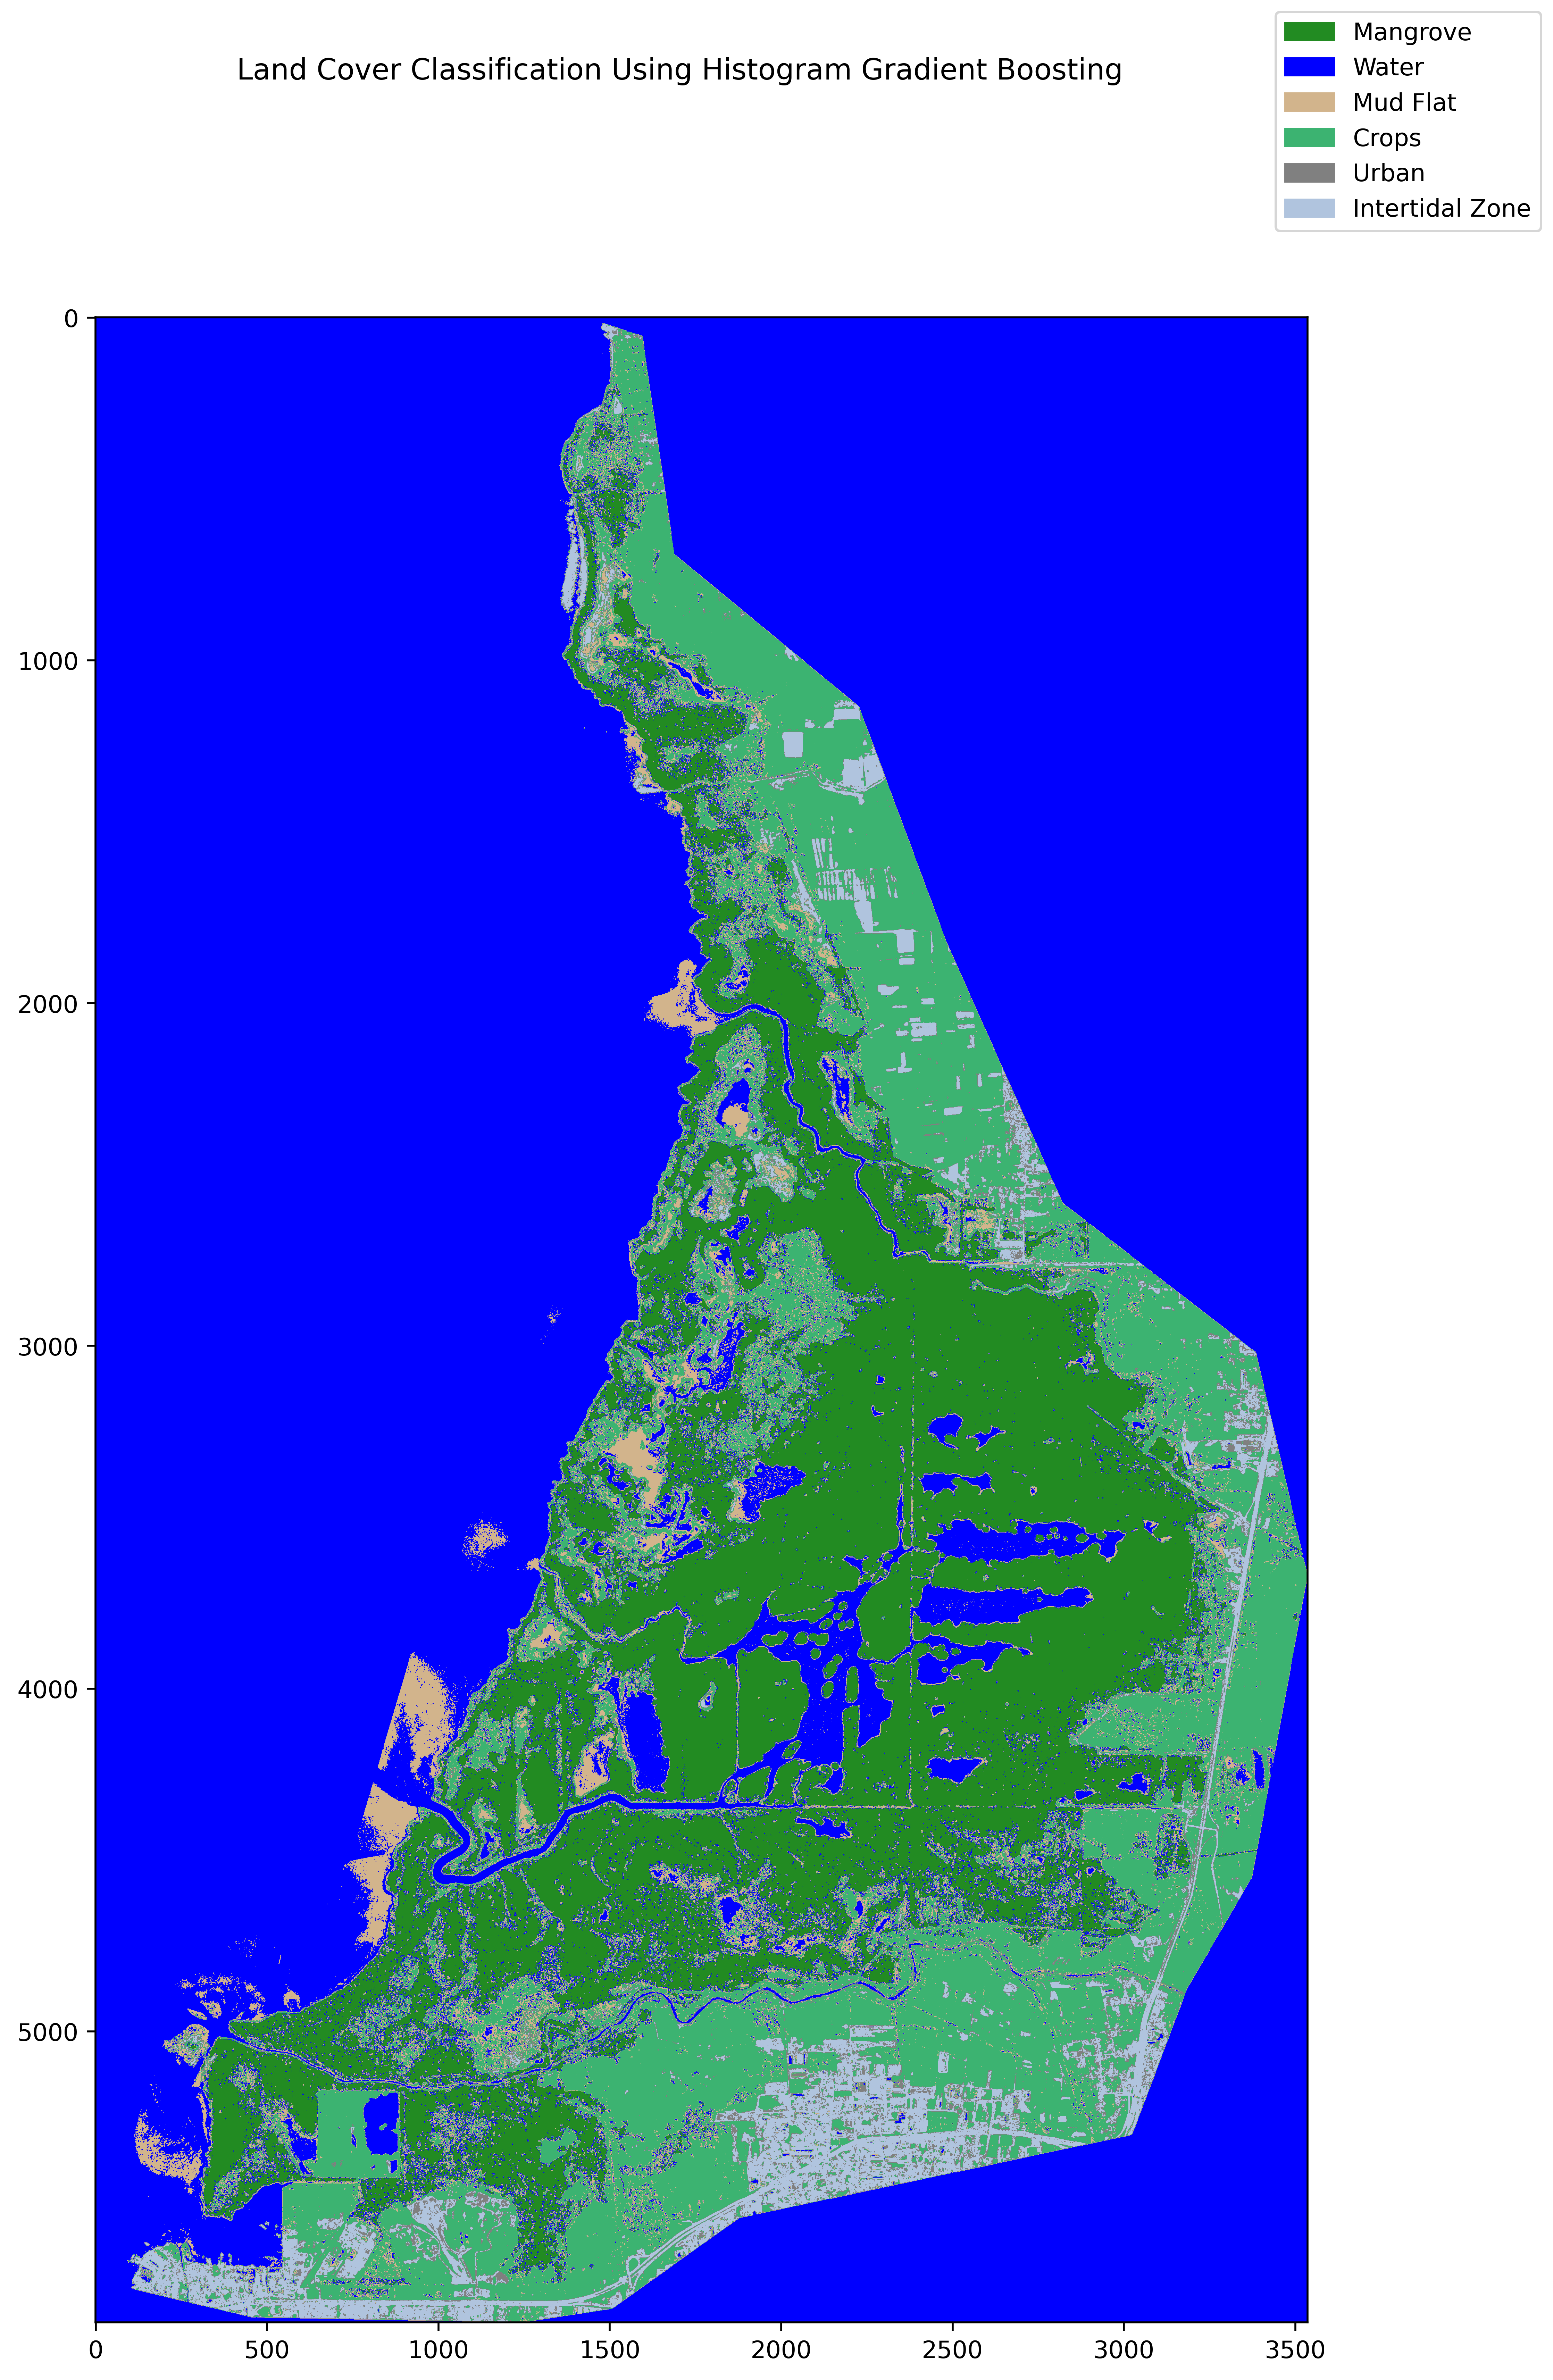

In [17]:
fig, ax = plt.subplots(figsize=((10,15)), dpi=500)
ax.imshow(hgb_classified, cmap=custom_cmap)
fig.legend(handles=patches)
fig.suptitle('Land Cover Classification Using Histogram Gradient Boosting')
#fig.patch.set_facecolor('xkcd:white')
plt.show()

## Validation

### Reminders:
In order to rebuild a similar model with future versions of scikit-learn, additional metadata should be saved along the pickled model:

The training data, e.g. a reference to an immutable snapshot

The python source code used to generate the model

The versions of scikit-learn and its dependencies

The cross validation score obtained on the training data

This should make it possible to check that the cross-validation score is in the same range as before.

## Dumping Model for Classification Use

In [18]:
dump(hgb, '../'+CLASSIFIER_PATH)

['../models/hgb_classifier.joblib']